In [172]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
!pip3 install pywavelets

In [173]:
img = cv.imread("5184.jpg")
img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

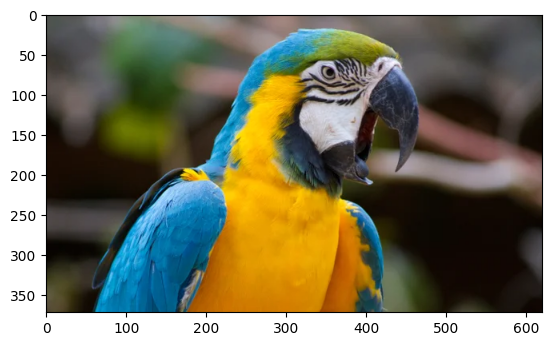

In [174]:
plt.figure()

plt.imshow(img, cmap = 'gray')

In [175]:
import cv2
import numpy as np

def generate_gaussian_pyramid(img, levels):

    gaussian_pyramid = [img]
    current_image = img.copy()
    for i in range(1, levels):
        # Reduce the image size by half using interpolation
        height = current_image.shape[0] // 2
        width = current_image.shape[1] // 2
        resized_image = cv2.resize(current_image, (width, height), interpolation=cv2.INTER_LINEAR)
        gaussian_pyramid.append(resized_image)
        #for J =3 gaussian_pyramid[0] = img = g3, gaussian_pyramid[1] = g2, gaussian_pyramid[2] = g1
        current_image = resized_image
    return gaussian_pyramid

def generate_laplacian_pyramid(img, levels):

    gaussian_pyramid = generate_gaussian_pyramid(img, levels)
    laplacian_pyramid = []

    for i in range(levels - 1):

        current_gaussian = gaussian_pyramid[i]

        next_gaussian = gaussian_pyramid[i + 1]

        # Upsample the next Gaussian image to the size of the current one
        height, width = current_gaussian.shape[:2]
        upsampled = cv2.resize(next_gaussian, (width, height), interpolation=cv2.INTER_CUBIC)

        # Calculate the Laplacian image by subtracting the upsampled image from the current Gaussian image
        laplacian = cv2.subtract(current_gaussian, upsampled)
        laplacian_pyramid.append(laplacian)
         # for j =3 ; l0 = g3-cv2.resize(g2), l1 = g2-cv2.resize(g1), l2 = g1 (added in the next step)

    # The last level of the Laplacian pyramid is the smallest Gaussian image
    laplacian_pyramid.append(gaussian_pyramid[-1])

    return laplacian_pyramid

def reconstruct_laplacian_pyramid(laplacian_pyramid):
  print(len(laplacian_pyramid))
  n = len(laplacian_pyramid)
  reconstructed_image = laplacian_pyramid[-1]
  for i in range(len(laplacian_pyramid) - 2, -1, -1):
      height,width  = (laplacian_pyramid[i].shape[:2])
      upsampled = cv2.resize(reconstructed_image, (width,height),interpolation=cv2.INTER_CUBIC)
      reconstructed_image = (upsampled + laplacian_pyramid[i])
  return reconstructed_image


Text(0.5, 1.0, 'Laplacian Pyramid')

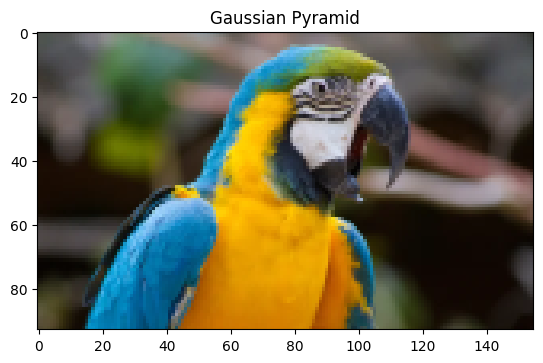

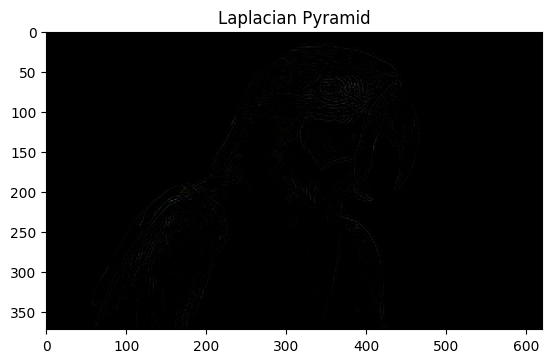

In [190]:
im_gauss = generate_gaussian_pyramid(img, 3)[-1]
plt.figure()
plt.imshow(im_gauss, cmap = 'gray')
plt.title("Gaussian Pyramid")
im_laplacian = generate_laplacian_pyramid(img, 3)[0]
plt.figure()
plt.imshow(im_laplacian, cmap = 'gray')
plt.title("Laplacian Pyramid")

In [191]:
def quantize_pyramid(lap_pyramid, q):
    quantized_pyramid = []
    for i in range(len(lap_pyramid)):
        c = lap_pyramid[i].astype(np.float32)
        quantized_level = ((np.round(c / q) + 0.5) * q)
        quantized_pyramid.append(quantized_level)
    return quantized_pyramid



4
4
4
4
4
4
4
4
4


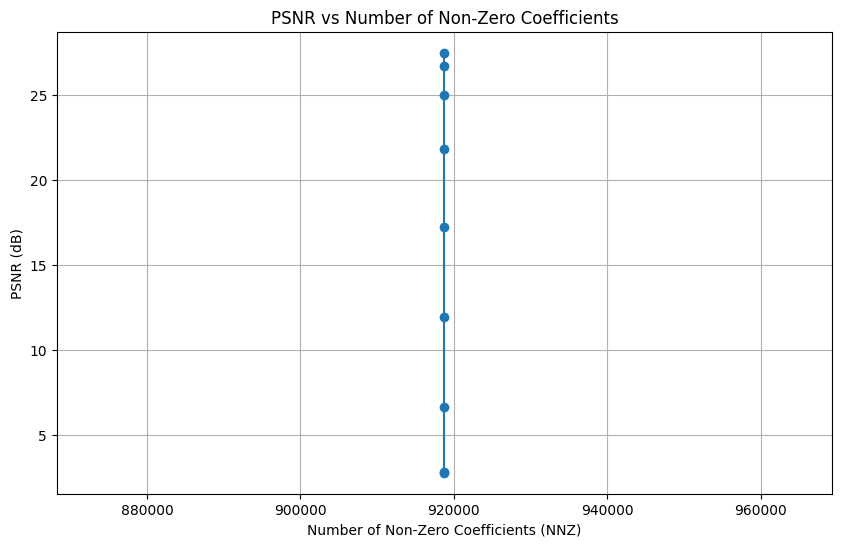

In [192]:
# Function to compute PSNR
def compute_psnr(original, reconstructed):
    mse = np.mean((original.astype(np.float32) - reconstructed.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10((255 ** 2) / mse)

# Main script
levels = 4  # Pyramid levels J = 0, 1, 2, 3
qs = [2 ** n for n in range(9)]  # Quantization step sizes q = 2^n, n = 0, 1, ..., 8

psnr_results = []
non_zero_counts = []

# Generate the Laplacian pyramid
laplacian_pyramid = generate_laplacian_pyramid(img, levels)

# Loop through each quantization step size
for q in qs:
    # Quantize the pyramid
    quantized_pyramid = quantize_pyramid(laplacian_pyramid, q)

    # Reconstruct the image from the quantized pyramid
    reconstructed_img = reconstruct_laplacian_pyramid(quantized_pyramid)

    # Ensure the reconstructed image is in the same data type as the original
    reconstructed_img = np.clip(reconstructed_img, 0, 255).astype(img.dtype)

    # Compute PSNR between the original and reconstructed images
    psnr = compute_psnr(img, reconstructed_img)
    psnr_results.append(psnr)

    # Count the number of non-zero coefficients in the quantized pyramid
    nnz = sum(np.count_nonzero(level) for level in quantized_pyramid)
    non_zero_counts.append(nnz)

# Plot PSNR vs Number of Non-Zero Coefficients
plt.figure(figsize=(10, 6))
plt.plot(non_zero_counts, psnr_results, marker='o')
plt.xlabel('Number of Non-Zero Coefficients (NNZ)')
plt.ylabel('PSNR (dB)')
plt.title('PSNR vs Number of Non-Zero Coefficients')
plt.grid(True)
plt.show()

In [239]:
import pywt

# definition of wavelet_transform to perform wavelet transform using dwt2 function
def wavelet_transform(img, levels,wavelet='haar'):
    coeffs_list = []
    current_img = img.astype(np.float32)
    for level in range(levels):
        # Perform single-level DWT
        cA, (cH, cV, cD) = pywt.dwt2(current_img, wavelet=wavelet, mode='symmetric')
        coeffs_list.append((cH, cV, cD))
        current_img = cA  # Use approximation coefficients for next level
    # At the end, current_img is the approximation coefficients at the deepest level
    coeffs_list.append(current_img)
    return coeffs_list

  # definition of wavelet_transform to perform reconstruction using idwt2 function
def reconstructed_wavelet(coeffs_list,wavelet = 'haar'):
    coeffs = coeffs_list[::-1]  # Reverse the order of coefficients for reconstruction
    cA, coeffs_list = coeffs[0], coeffs[1:]
    for cH, cV, cD in coeffs_list:
        cA = pywt.idwt2((cA, (cH, cV, cD)), wavelet=wavelet, mode='symmetric')

    return cA

In [240]:
def quantize_coeffs(coeffs, q):

    cA, coeffs_list = coeffs
    μ_cA = 128  # Mean for approximation coefficients
    cA_q = q * (np.round((cA - μ_cA) / q) + 0.5) + μ_cA

    quantized_coeffs_list = []
    μ_cd = 0  # Mean for detail coefficients
    for cH, cV, cD in coeffs_list:
        cH_q = q * (np.round((cH - μ_cd) / q) + 0.5) + μ_cd
        cV_q = q * (np.round((cV - μ_cd) / q) + 0.5) + μ_cd
        cD_q = q * (np.round((cD - μ_cd) / q) + 0.5) + μ_cd
        quantized_coeffs_list.append((cH_q, cV_q, cD_q))

    quantized_coeffs = (cA_q, quantized_coeffs_list)
    return quantized_coeffs


In [244]:
levels = 3
coeffs = wavelet_transform(img, levels)
# Reconstruct the image
reconstructed_img = reconstructed_wavelet(coeffs)
# Ensure pixel values are valid
reconstructed_img = np.clip(reconstructed_img, 0, 255).astype(np.uint8)
# Display the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title('Reconstructed Image from Wavelet Transform')
plt.axis('off')

ValueError: `coeffs` must all be of equal size (or None)

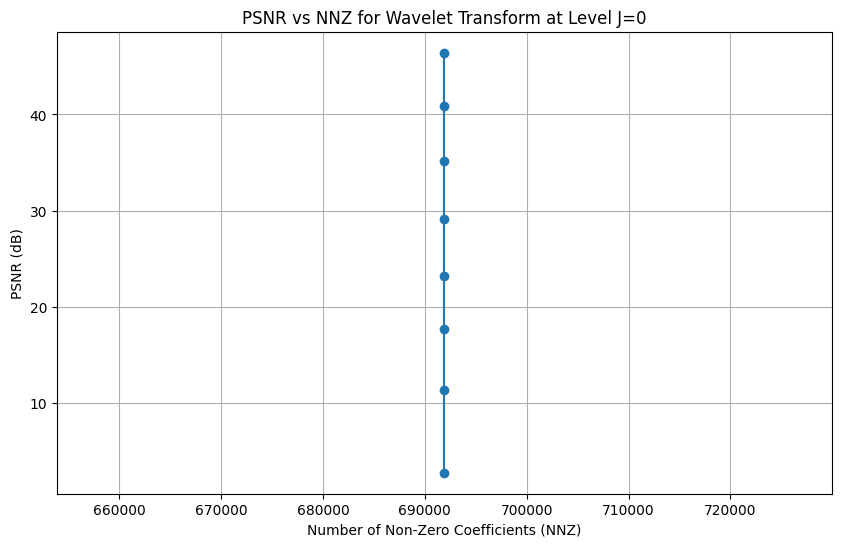

TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

In [242]:
# Function to compute PSNR
def compute_psnr(original, reconstructed):
    mse = np.mean((original.astype(np.float32) - reconstructed.astype(np.float32)) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel_value = 255.0  # Assuming 8-bit images
    return 10 * np.log10((max_pixel_value ** 2) / mse)

levels_list = [0, 1, 2, 3]  # Pyramid levels J = 0, 1, 2, 3
qs = [2 ** n for n in range(9)]  # Quantization step sizes q = 2^n, n = 0, 1, ..., 8

for levels in levels_list:
    psnr_results = []
    non_zero_counts = []

    if levels == 0:
        # No decomposition; coefficients are the image itself
        coeffs = [img.astype(np.float32)]
    else:
        # Perform wavelet decomposition
        coeffs = wavelet_transform(img, levels)

    for q in qs:
        # Quantize the coefficients
        if levels == 0:
            # Quantize the image directly
            cA = coeffs[0]
            μ = 128  # Mean for approximation coefficients
            cA_q = q * (np.round((cA - μ) / q) + 0.5) + μ
            quantized_coeffs = [cA_q]
        else:
            quantized_coeffs = quantize_coeffs(coeffs, q)

        # Reconstruct the image
        if levels == 0:
            reconstructed_img = quantized_coeffs[0]
        else:
            reconstructed_img = reconstruct_wavelet(quantized_coeffs)
        # Clip values and convert to original data type
        reconstructed_img = np.clip(reconstructed_img, 0, 255).astype(img.dtype)

        # Compute PSNR
        psnr = compute_psnr(img, reconstructed_img)
        psnr_results.append(psnr)

        # Compute NNZ (Number of Non-Zero Coefficients)
        if levels == 0:
            nnz = np.count_nonzero(quantized_coeffs[0])
        else:
            nnz = 0
            for c in quantized_coeffs:
                if isinstance(c, tuple):
                    nnz += np.count_nonzero(c[0]) + np.count_nonzero(c[1]) + np.count_nonzero(c[2])
                else:
                    nnz += np.count_nonzero(c)
        non_zero_counts.append(nnz)

    # Plot PSNR vs NNZ
    plt.figure(figsize=(10, 6))
    plt.plot(non_zero_counts, psnr_results, marker='o')
    plt.xlabel('Number of Non-Zero Coefficients (NNZ)')
    plt.ylabel('PSNR (dB)')
    plt.title(f'PSNR vs NNZ for Wavelet Transform at Level J={levels}')
    plt.grid(True)
    plt.show()


In [ ]:
# Perform 3-level wavelet transform
levels = 3
coeffs = wavelet_transform(img, levels)

# Reconstruct the image
reconstructed_img = reconstructed_wavelet(coeffs)
reconstructed_img = np.clip(reconstructed_img, 0, 255).astype(np.uint8)

# Verify reconstruction
psnr = compute_psnr(img, reconstructed_img)
print(f'PSNR between original and reconstructed image: {psnr:.2f} dB')

# Display the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray')
plt.title('Reconstructed Image from Wavelet Transform')
plt.axis('off')
plt.show()
